<a href="https://colab.research.google.com/github/hoangducsn00/cifar100---86.09-/blob/main/cifar100_86_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

In [ ]:
ds, info = tfds.load(name='cifar100',
                     shuffle_files=True,
                     with_info=True)
num_examples = info.splits['train'].num_examples
NUM_CLASSES = 100

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.0.incompleteU3D7YX/cifar100-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.0.incompleteU3D7YX/cifar100-test.tfrecord


Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.0. Subsequent calls will reuse this data.


In [ ]:
train_split = 0.9
num_train = int(train_split * num_examples)
ds_train = ds['train'].take(num_train)
ds_valid = ds['train'].skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_train

ds_test = ds['test']

In [ ]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=True)

In [ ]:
model = tf.keras.Sequential([
    module,
    tf.keras.layers.Dense(NUM_CLASSES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [ ]:
model.build((None,)+(128,128)+(3,))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
Total params: 23,705,252
Trainable params: 23,705,252
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RESIZE_TO = 160
CROP_TO = 128
SCHEDULE_LENGTH = 5000
SCHEDULE_BOUNDARIES = [1000, 2000, 3000]

In [ ]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 320
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features



In [ ]:
pipeline_train = (ds_train
                  .shuffle(45000).cache() # Shuffle and keep data fit in memory
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1) # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.experimental.AUTOTUNE))

pipeline_valid = (ds_valid.map(preprocess_test, num_parallel_calls=1).cache()
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.experimental.AUTOTUNE))   # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.

In [ ]:
# Define optimiser and loss
lr = 0.002 * BATCH_SIZE / 512
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/Course_work_1/cw1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# Feature extractor model
history = model.fit(pipeline_train,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    callbacks= callbacks_list,
                    epochs= 180,  
                    validation_data=pipeline_valid)

Epoch 1/180
10/10 [==============================] - ETA: 0s - loss: 7.4256 - accuracy: 0.0225
Epoch 00001: val_accuracy improved from -inf to 0.04500, saving model to /content/drive/My Drive/Course_work_1/cw1.h5
10/10 [==============================] - 30s 3s/step - loss: 7.4256 - accuracy: 0.0225 - val_loss: 4.7635 - val_accuracy: 0.0450
Epoch 2/180
10/10 [==============================] - ETA: 0s - loss: 4.2651 - accuracy: 0.0975
Epoch 00002: val_accuracy improved from 0.04500 to 0.17040, saving model to /content/drive/My Drive/Course_work_1/cw1.h5
10/10 [==============================] - 21s 2s/step - loss: 4.2651 - accuracy: 0.0975 - val_loss: 3.5802 - val_accuracy: 0.1704
Epoch 3/180
10/10 [==============================] - ETA: 0s - loss: 3.0782 - accuracy: 0.2509
Epoch 00003: val_accuracy improved from 0.17040 to 0.34520, saving model to /content/drive/My Drive/Course_work_1/cw1.h5
10/10 [==============================] - 21s 2s/step - loss: 3.0782 - accuracy: 0.2509 - val_loss

In [ ]:
pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [ ]:
model.load_weights('/content/drive/My Drive/Course_work_1/cw1.h5')

In [ ]:
model.evaluate(pipeline_test)

32/32 [==============================] - 18s 577ms/step - loss: 0.5303 - accuracy: 0.8609


[0.530295729637146, 0.8608999848365784]

In [ ]:
save_path = '/content/drive/My Drive/Course_work_1/save'

In [ ]:
tf.saved_model.save(model, save_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /content/drive/My Drive/Course_work_1/save/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Course_work_1/save/assets


#Visualization

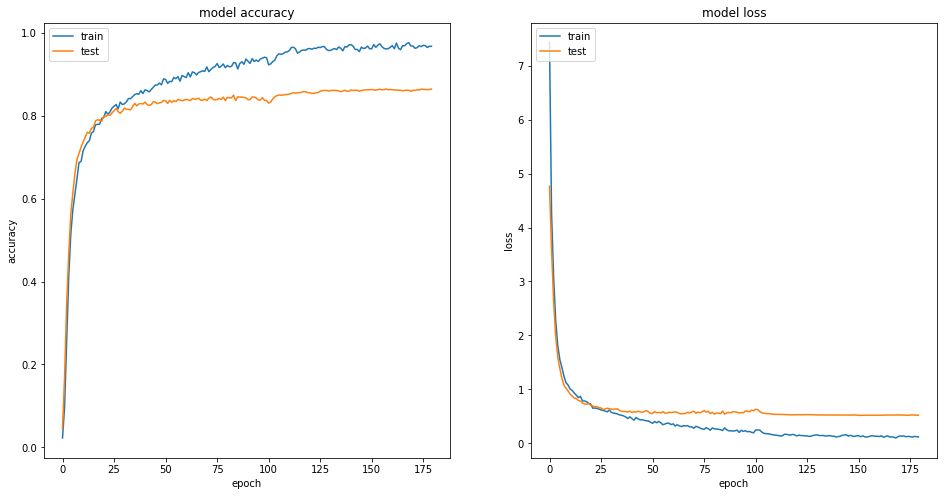

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

